## 클러스터링

간단한 k-평균 알고리즘을 사용하여 클러스터링을 수행하는 방법을 보여드립니다. 클러스터링은 데이터 내에서 가치 있고 숨겨진 그룹을 발견하는 데 도움이 될 수 있습니다. 데이터 집합은 [데이터 집합 가져오기 노트북](Obtain_dataset.ipynb)에서 생성됩니다.

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Obtain_dataset Notebook](Obtain_dataset.ipynb).

In [2]:
# imports
import numpy as np
import pandas as pd

# load data
datafile_path = "./data/fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape


(1000, 1536)

### 1. K-평균을 사용해 클러스터 찾기

가장 간단한 K-평균 사용법을 보여드리겠습니다. 사용 사례에 가장 적합한 클러스터 수를 선택할 수 있습니다.

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [44]:
from sklearn.cluster import KMeans

n_clusters = 7

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
3    3.289855
1    4.166667
6    4.248062
0    4.339130
4    4.345679
2    4.458763
5    4.611465
Name: Score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

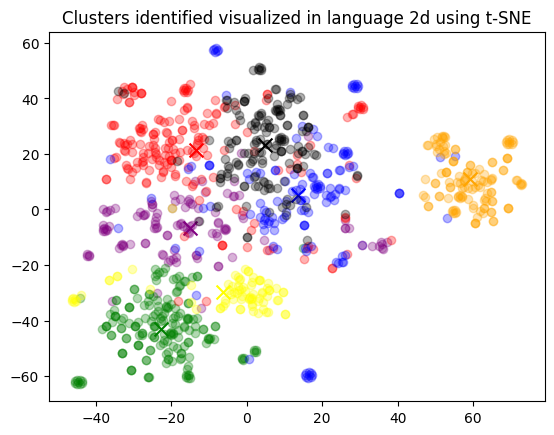

In [41]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "yellow", "black", "orange"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


2D 투영으로 클러스터를 시각화합니다. 이 실행에서 녹색 클러스터(1번)는 다른 클러스터와 상당히 다르게 보입니다. 각 클러스터의 몇 가지 샘플을 살펴보겠습니다.

Visualization of clusters in a 2d projection. In this run, the green cluster (#1) seems quite different from the others. Let's see a few samples from each cluster.

### 2. 클러스터의 텍스트 샘플 및 클러스터 이름 지정하기

각 클러스터의 무작위 샘플을 표시해 보겠습니다. 해당 클러스터에서 무작위로 추출한 리뷰 5개 샘플을 기반으로 text-davinci-003을 사용하여 클러스터의 이름을 지정하겠습니다.

Let's show random samples from each cluster. We'll use text-davinci-003 to name the clusters, based on a random sample of 5 reviews from that cluster.

In [46]:
import openai

# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", " ")
        .str.replace(" Content: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    # print(reviews)
    print("\n\nPrompt:" )
    print("." * 100)
    print(f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews[:100]}\n"""\n\nTheme:')
    print("." * 100)
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )

    
    print("\n\nResponse:" )
    print("." * 100)
    print(response["choices"][0]["text"].replace("\n", ""))
    print("." * 100)

    print("\n\nSamples:" )
    print("." * 100)
    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])
    print("." * 100)

    print("-" * 100)


Cluster 0 Theme: 

Prompt:
....................................................................................................
What do the following customer reviews have in common?

Customer reviews:
"""
 This is a Wonderful Wine;:  I really enjoy this wine!  I was a little skeptical about it at first b
"""

Theme:
....................................................................................................


Response:
....................................................................................................
 All of the reviews are positive and describe the product in detail. They all mention the taste of the product and provide additional information about where to purchase it or what ingredients it contains.
....................................................................................................


Samples:
....................................................................................................
5, This is a Wonderful Wine:   I really enjoy th

클러스터가 반드시 사용하려는 용도와 일치하지는 않는다는 점에 유의해야 합니다. 클러스터의 양이 많을수록 보다 구체적인 패턴에 초점을 맞출 수 있는 반면, 클러스터의 수가 적을수록 일반적으로 데이터의 가장 큰 불일치에 초점을 맞출 수 있습니다.

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.